[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VilohitT/llm-thought-tracing/blob/main/notebooks/geographical_reasoning_notebook.ipynb)

## Setup and Dependencies


In [ ]:
# Install required packages
!pip install transformer-lens matplotlib seaborn numpy torch matplotlib pillow


In [2]:
# Clone the repo
!git clone https://github.com/VilohitT/llm-thought-tracing.git

%cd llm-thought-tracing

Cloning into 'llm-thought-tracing'...
remote: Enumerating objects: 342, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 342 (delta 0), reused 0 (delta 0), pack-reused 341 (from 1)
Receiving objects: 100% (342/342), 31.91 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (179/179), done.
/content/llm-thought-tracing


In [ ]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import seaborn as sns
from transformer_lens import HookedTransformer
from IPython.display import display, Markdown, HTML
import matplotlib.animation as animation
import warnings

from llm_reasoning_tracer.concept_extraction import extract_concept_activations
from llm_reasoning_tracer.reasoning_analysis import analyze_reasoning_paths
from llm_reasoning_tracer.causal_intervention import perform_causal_intervention
from llm_reasoning_tracer.visualization import (
    plot_concept_activation_heatmap,
    animate_concept_activation_diagonal,
    animate_reasoning_flow,
    animate_reasoning_flow_dark,
    plot_layer_position_intervention,
    save_animation
)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## Load the Model

We'll use the Llama 3.2-3B-Instruct model, which provides a good balance between performance and computational requirements. For geographical tasks, this size of model typically demonstrates solid factual knowledge.


In [4]:
from google.colab import userdata
from huggingface_hub import login

hf_key = userdata.get('hf_key')
login(hf_key)

In [ ]:
def load_llama_3_2():
    return HookedTransformer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct", device="cuda")

model = load_llama_3_2()
print(f"Loaded model: {model.cfg.model_name}")
print(f"Number of layers: {model.cfg.n_layers}")
print(f"Number of attention heads: {model.cfg.n_heads}")
print(f"Hidden size: {model.cfg.d_model}")

# Enable attention result caching for detailed analysis
model.cfg.use_attn_result = True


### 🧠 Multi-Step Reasoning: Dallas → Texas → Austin

In [6]:
# Define the prompt and concepts
geo_prompt = "Fact: Dallas exists in the state whose capital is"

# Define potential intermediate and final concepts
geo_intermediates = ["Texas"]
geo_finals = ["Austin"]

# Define potential reasoning paths
geo_paths = [
    ["Dallas", "Texas", "Austin"],  # Expected multi-hop path
    ["Dallas", "Austin"],           # Direct path (skipping state)
    ["state", "capital", "Austin"]  # Abstract reasoning path
]

# Print the prompt and expected reasoning path
display(Markdown(f"**Prompt:** {geo_prompt}"))
display(Markdown(f"**Expected reasoning path:** Dallas → Texas → Austin"))


**Prompt:** Fact: Dallas exists in the state whose capital is

**Expected reasoning path:** Dallas → Texas → Austin

### 📊 Step 1: Extracting Concept Activations



In [7]:
# Extract concept activations
geo_concept_results = extract_concept_activations(
    model,
    geo_prompt,
    intermediate_concepts=geo_intermediates,
    final_concepts=geo_finals
)

# Print a summary of activations
display(Markdown("### Concept Activation Summary:"))
for concept in geo_intermediates + geo_finals:
    if concept in geo_concept_results["activations"]:
        activations = geo_concept_results["activations"][concept]
        if activations:
            # Get the strongest activation
            strongest = max(activations, key=lambda x: x["probability"])
            display(Markdown(f"- **{concept}**: Strongest activation at layer {strongest['layer']}, position {strongest['position']} (token: '{strongest['context_token']}'), logit: {strongest['probability']:.4f}"))
        else:
            display(Markdown(f"- **{concept}**: No significant activations found"))


### Concept Activation Summary:

- **Texas**: Strongest activation at layer 27, position 6 (token: ' state'), logit: 6.9765

- **Austin**: Strongest activation at layer 27, position 9 (token: ' is'), logit: 8.0483

### 🎨 Step 2: Visualizing Concept Evolution Across Layers & Positions



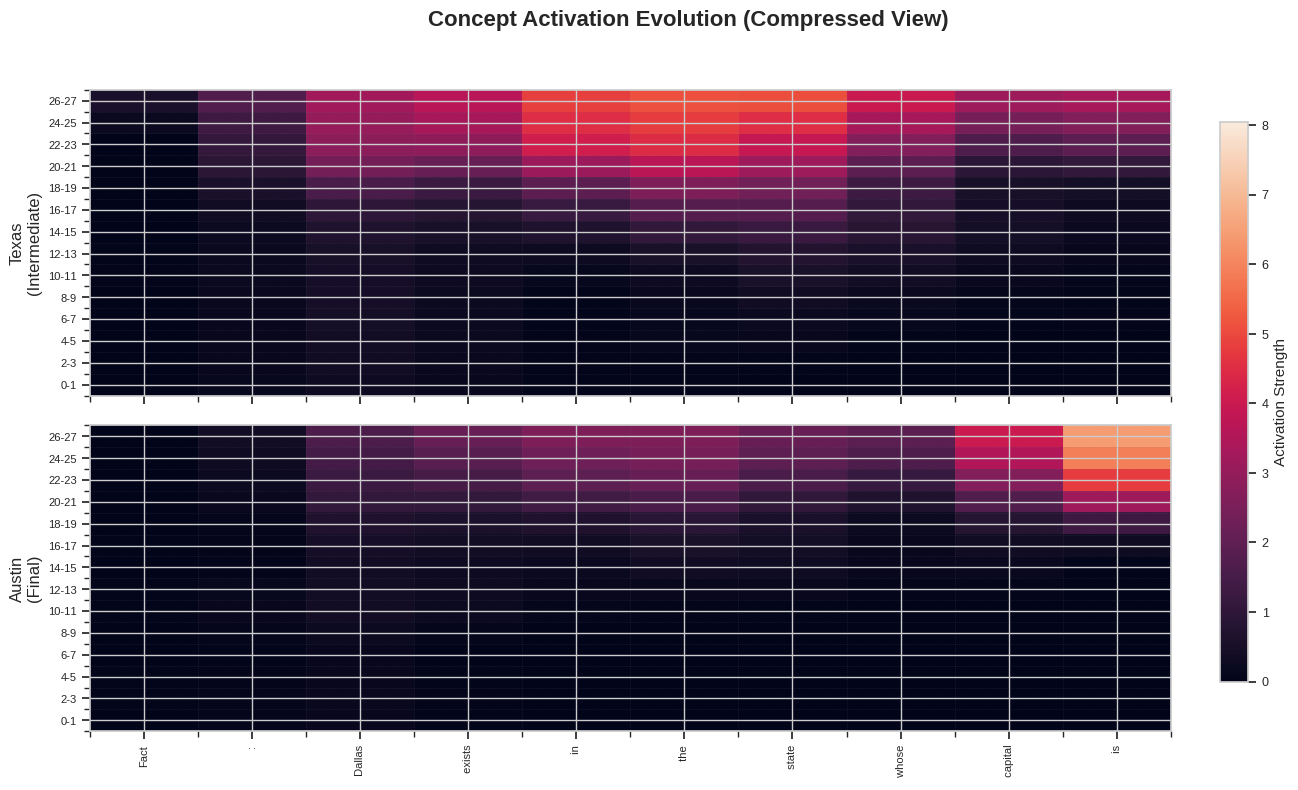

<Figure size 640x480 with 0 Axes>

In [8]:
# Visualize concept evolution
fig1 = plot_concept_activation_heatmap(geo_concept_results)
plt.tight_layout()
fig1.savefig("figures/geo_compressed_concept_activation_heatmap.png", dpi=300, bbox_inches='tight')
display(fig1)


### Dynamic Concept Activation


In [9]:
# Animate concept activation for Texas
ani = animate_concept_activation_diagonal(geo_concept_results, selected_concepts=["Texas"])
display(HTML(ani.to_jshtml()))
ani.save("figures/texas_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)

In [10]:
# Animate concept activation for Austin
ani = animate_concept_activation_diagonal(geo_concept_results, selected_concepts=["Austin"])
display(HTML(ani.to_jshtml()))
ani.save("figures/austin_activation_diagonal.gif", writer=PillowWriter(fps=10), dpi=300)



### 🧠 Step 3: Tracing Reasoning Paths Across Layers


In [11]:
# Analyze reasoning paths
geo_path_results = analyze_reasoning_paths(
    model,
    geo_prompt,
    potential_paths=geo_paths,
    concept_threshold=0.1
)

# Print path scores
display(Markdown("### Reasoning Path Scores:"))
for path_data in geo_path_results["path_scores"]:
    path = path_data["path"]
    score = path_data["score"]
    complete = path_data.get("complete", False)
    in_order = path_data.get("in_order", False)

    path_str = " → ".join(path)
    status = ""
    if not complete:
        status = "(Missing concepts)"
    elif not in_order:
        status = "(Out of order)"

    display(Markdown(f"- **{path_str}**: {score:.4f} {status}"))

# Print best path
if geo_path_results["best_path"]:
    best_path = " → ".join(geo_path_results["best_path"])
    display(Markdown(f"**Best path:** {best_path} (score: {geo_path_results['best_path_score']:.4f})"))


### Reasoning Path Scores:

- **Dallas → Texas → Austin**: 1.0000 

- **Dallas → Austin**: 1.0000 

- **state → capital → Austin**: 0.5000 (Out of order)

**Best path:** Dallas → Texas → Austin (score: 1.0000)

### 🎬 Step 4: Visualizing the Full Reasoning Trajectory


In [12]:
# Get tokens and animate reasoning flow
tokens = model.to_str_tokens(geo_prompt)

# Light theme animation
anim = animate_reasoning_flow(
    geo_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers
)
display(HTML(anim.to_jshtml()))


In [13]:
anim = save_animation(
    path_results=geo_path_results,
    tokens=tokens[1:],
    model_layers=model.cfg.n_layers,
    output_path="figures/reasoning_flow_geographical_dark.gif",
    format="gif",
    fps=1,
    dpi=300
)

Animation saved to figures/reasoning_flow_geographical_dark.gif


### 🧠 Step 5: Causal Tracing – How Does Corruption Affect the Model's Belief?

In [14]:
# Perform causal intervention (limited to position 3 for demonstration)
geo_intervention_results = perform_causal_intervention(
    model,
    geo_prompt,
    concepts=["Austin"],
    target_positions=[3]        # "Dallas" corrupted to "Chicago"
)

# Print top influential tokens for each concept
display(Markdown("### Most Influential Tokens:"))
for concept in ["Austin"]:
    display(Markdown(f"**For concept '{concept}':**"))
    for i, influence in enumerate(geo_intervention_results["token_importance"][concept][:5]):
        display(Markdown(f"- **{influence['token']}** (position {influence['position']}): Effect = {influence['effect']:.4f}"))


### Most Influential Tokens:

**For concept 'Austin':**

- ** Dallas** (position 3): Effect = 2.7195

### 🔬 Visualizing Causal Influence Across Layers and Positions


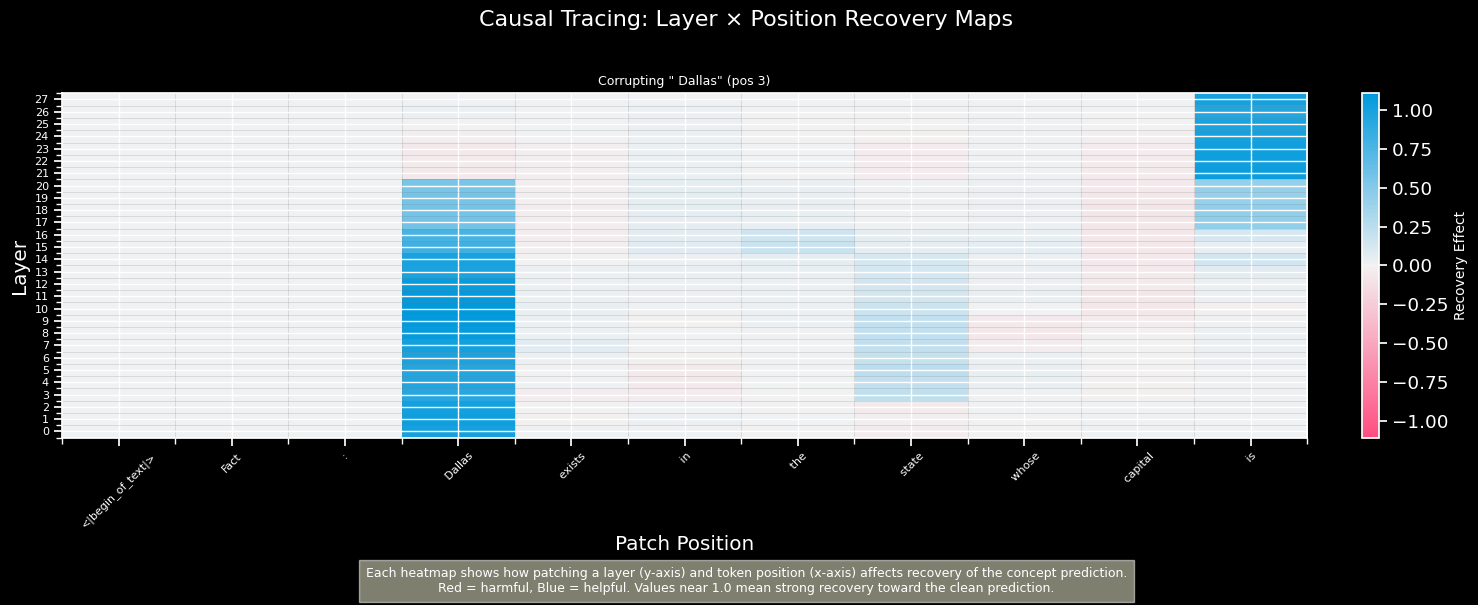

<Figure size 640x480 with 0 Axes>

In [15]:
# Visualize causal intervention
fig4 = plot_layer_position_intervention(geo_intervention_results)
plt.tight_layout()
fig4.savefig("figures/geo_causal_intervention.png", dpi=300, bbox_inches='tight')
display(fig4)
